In [1]:
from init_nb import init_notebook
config = init_notebook()

from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import numpy as np
import seaborn as sns
from nilearn import plotting
import nibabel as nib
import itertools

from bold_dementia.connectivity import Atlas, group_by_networks, plot_matrix, reshape_pvalues
from bold_dementia.utils.iterables import unique

ATLAS = "schaeffer200"
SOFT = False
ALPHA = config["alpha"]
PREFIX = "DEBUG"

In [2]:
atlas = Atlas.from_name(ATLAS, soft=SOFT)
coords = atlas.get_coords()

In [3]:
matrices_path = Path(
    f"{config['output_dir']}/connectivity/atlas-{ATLAS}_{PREFIX}_default"
)
AD_matrices = joblib.load(matrices_path / "AD.joblib")
control_matrices = joblib.load(matrices_path / "control.joblib")
#fdrmat = joblib.load(matrices_path / "fdr_mat.joblib")
#tstats = joblib.load(matrices_path / "tstats.joblib")
fdrmat = joblib.load(matrices_path / "glm_pvalues.joblib")
tstats = joblib.load(matrices_path / "glm_stat.joblib")



n_AD = AD_matrices.shape[0]
n_controls = control_matrices.shape[0]

atlas = Atlas.from_name(ATLAS, soft=SOFT)
n_regions = len(atlas.labels)

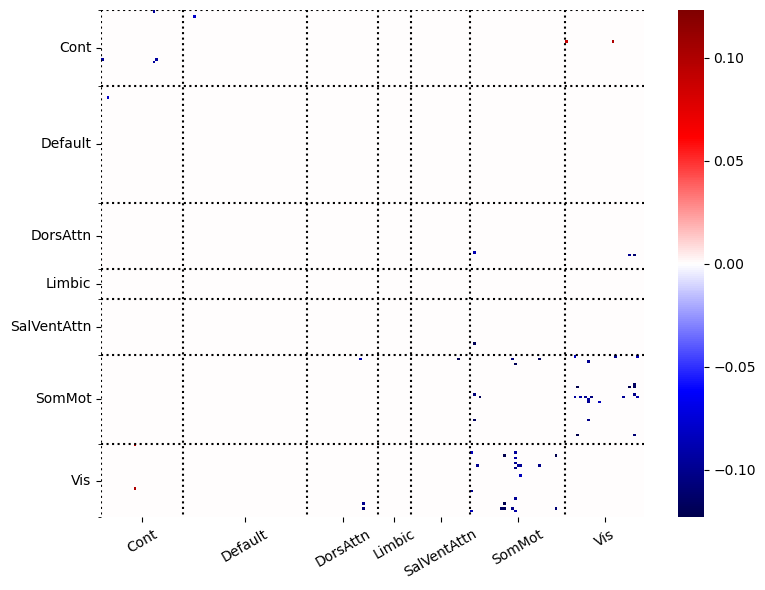

In [12]:
thresholded_t = tstats * np.where(fdrmat < ALPHA, 1, 0)
plot_matrix(thresholded_t, atlas, True)
plt.show()

In [5]:
ticks, sort_index = group_by_networks(atlas.macro_labels)
block_mat = thresholded_t[np.ix_(sort_index, sort_index)]
ticks

Cont
Default
DorsAttn
Limbic
SalVentAttn
SomMot
Vis


[0, 30, 76, 102, 114, 136, 171, 200]

In [6]:
unique_m = sorted(tuple(unique(atlas.macro_labels)))
network_to_idx = pd.Series(dict(zip(
    unique_m,
    itertools.pairwise(ticks)
)))
network_to_idx

Cont              (0, 30)
Default          (30, 76)
DorsAttn        (76, 102)
Limbic         (102, 114)
SalVentAttn    (114, 136)
SomMot         (136, 171)
Vis            (171, 200)
dtype: object

In [7]:
# TODO Allow (self, self) with chaining
def block_count(matrix, network_to_idx, combinations=itertools.combinations):
    for network_a, network_b in combinations(network_to_idx.index, 2):
            loc_a, loc_b = network_to_idx[network_a], network_to_idx[network_b]
            block = matrix[loc_a[0]:loc_a[1], loc_b[0]:loc_b[1]]
            n_positive_edges = np.count_nonzero(block > 0)
            n_negative_edges = np.count_nonzero(block < 0)
            
            block_size = (loc_a[1] - loc_a[0]) * (loc_b[1] - loc_b[0])
            block_activation = (n_negative_edges + n_negative_edges) / block_size

            yield network_a, network_b, n_positive_edges, n_negative_edges, block_activation

def intra_network_count(matrix, network_to_idx):
    intra_network = map(lambda x: (x, x), network_to_idx.index)
    for network_a, network_b in intra_network:
            loc_a, loc_b = network_to_idx[network_a], network_to_idx[network_b]
            block = matrix[loc_a[0]:loc_a[1], loc_b[0]:loc_b[1]]
            n_positive_edges = np.count_nonzero(block > 0)
            n_negative_edges = np.count_nonzero(block < 0)
            
            block_size = (loc_a[1] - loc_a[0]) * (loc_b[1] - loc_b[0])
            block_activation = (n_negative_edges + n_negative_edges) / block_size

            yield network_a, network_b, n_positive_edges, n_negative_edges, block_activation


In [13]:
count_vector

(('Cont', 'Default', 0, 1, 0.0014492753623188406),
 ('Cont', 'DorsAttn', 0, 0, 0.0),
 ('Cont', 'Limbic', 0, 0, 0.0),
 ('Cont', 'SalVentAttn', 0, 0, 0.0),
 ('Cont', 'SomMot', 0, 0, 0.0),
 ('Cont', 'Vis', 2, 0, 0.0),
 ('Default', 'DorsAttn', 0, 0, 0.0),
 ('Default', 'Limbic', 0, 0, 0.0),
 ('Default', 'SalVentAttn', 0, 0, 0.0),
 ('Default', 'SomMot', 0, 0, 0.0),
 ('Default', 'Vis', 0, 0, 0.0),
 ('DorsAttn', 'Limbic', 0, 0, 0.0),
 ('DorsAttn', 'SalVentAttn', 0, 0, 0.0),
 ('DorsAttn', 'SomMot', 0, 1, 0.002197802197802198),
 ('DorsAttn', 'Vis', 0, 2, 0.005305039787798408),
 ('Limbic', 'SalVentAttn', 0, 0, 0.0),
 ('Limbic', 'SomMot', 0, 0, 0.0),
 ('Limbic', 'Vis', 0, 0, 0.0),
 ('SalVentAttn', 'SomMot', 0, 1, 0.0025974025974025974),
 ('SalVentAttn', 'Vis', 0, 0, 0.0),
 ('SomMot', 'Vis', 0, 21, 0.041379310344827586))

In [16]:
reshape_pvalues(posvec)

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 2., 0., 0., 0.],
       [0., 0., 2., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])

In [29]:
arr = np.array([counts[0] + "<->" + counts[1] for counts in count_vector])

In [30]:
arr

array(['Cont<->Default', 'Cont<->DorsAttn', 'Cont<->Limbic',
       'Cont<->SalVentAttn', 'Cont<->SomMot', 'Cont<->Vis',
       'Default<->DorsAttn', 'Default<->Limbic', 'Default<->SalVentAttn',
       'Default<->SomMot', 'Default<->Vis', 'DorsAttn<->Limbic',
       'DorsAttn<->SalVentAttn', 'DorsAttn<->SomMot', 'DorsAttn<->Vis',
       'Limbic<->SalVentAttn', 'Limbic<->SomMot', 'Limbic<->Vis',
       'SalVentAttn<->SomMot', 'SalVentAttn<->Vis', 'SomMot<->Vis'],
      dtype='<U22')

In [8]:
count_vector = tuple(block_count(block_mat, network_to_idx))
diag_vector = tuple(intra_network_count(block_mat, network_to_idx))

diag_idx = list(range(len(unique_m)))


negvec = np.array([counts[3] for counts in count_vector])
negdiag = np.array([counts[3] for counts in diag_vector])
negmat = reshape_pvalues(negvec)
negmat[diag_idx, diag_idx] = negdiag

posvec = np.array([counts[2] for counts in count_vector])
posdiag = np.array([counts[2] for counts in diag_vector])
posmat = reshape_pvalues(posvec)
posmat[diag_idx, diag_idx] = posdiag

actvec = np.array([counts[4] for counts in count_vector])
actdiag = np.array([counts[4] for counts in diag_vector])
actmat = reshape_pvalues(actvec)
actmat[diag_idx, diag_idx] = actdiag


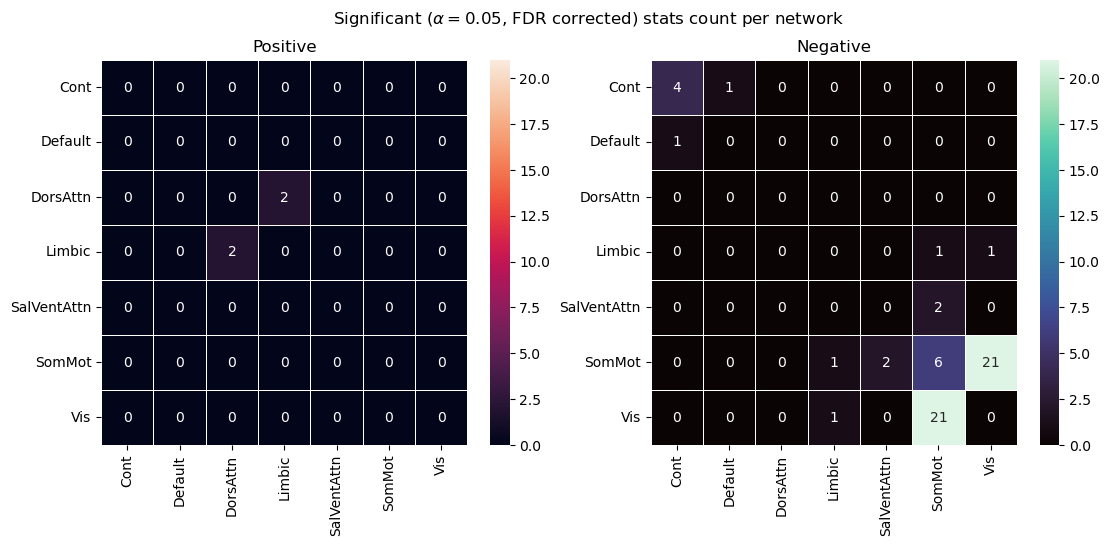

In [9]:
max_count = max(
    np.max(posmat),
    np.max(negmat),
)
heat_kwargs = {
    "xticklabels":unique_m,
    "yticklabels":unique_m,
    "vmax": max_count,
    "annot": True,
    "linewidth": 0.5
}
plt.rcParams.update({
    "text.usetex": False,
})

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
sns.heatmap(posmat, **heat_kwargs, cmap="rocket", ax=axes[0])
axes[0].set_title("Positive")
sns.heatmap(negmat, **heat_kwargs, cmap="mako", ax=axes[1])
axes[1].set_title("Negative")
fig.suptitle(f"Significant ($\\alpha = 0.05$, FDR corrected) stats count per network")
fig.show()

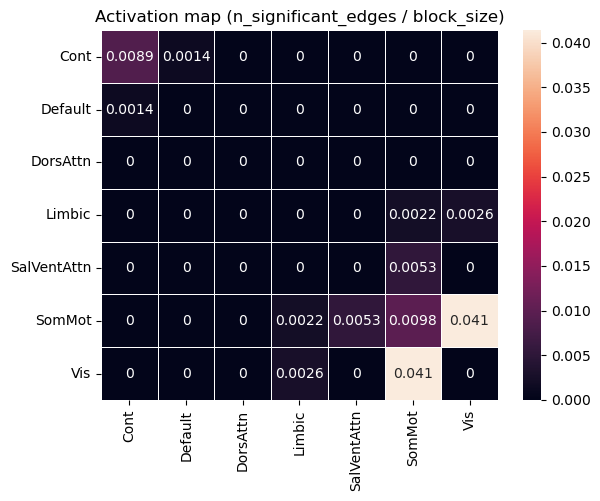

In [11]:
heat_k2 = heat_kwargs.copy()
heat_k2.pop("vmax")
sns.heatmap(actmat, **heat_k2)
plt.title("Activation map (n_significant_edges / block_size)")
plt.show()

In [ ]:
view = plotting.view_connectome(thresholded_t, coords, edge_threshold="90%")
view.open_in_browser()